In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from ipywidgets import interactive
#plt.style.use('ggplot')

----
## INHOUD:

* [AD Conversie](#Analog_Digital_Conversion)
    * [Sampling](#Sampling)
    * [Quantization](#Quantization)
    
    
----    

------------
## Analog Digital Conversion

Two steps are mandatory in order to do digital processing on analog signals.
![Analog, discrete and digital signals](figures/analog_discrete_digital.png)

---
# Sampling, Aliasing en Nyquist:


### Nyquist (Folding) frequency: $$\dfrac{f_s}{2}$$
### Nyquist rate: $$f_s=2 f_{max}$$
### Nyquist interval: $$\left[-\dfrac{f_s}{2}, \dfrac{f_s}{2}\right]$$

### Nyquist condition: $$f_s \geq 2 f_{max}$$
----

In [192]:
def aliasingExample(fs=2.1,f1=1):

    T = 1/fs #sampling period

    tstart = 0
    tend = 100

    dt = 1./100;

    t = np.arange(tstart,tend,dt) #time axis
    n = np.arange(tstart,tend*fs) #discrete time intervals 

    f2 = np.mod(f1,fs) #determine aliasing frequency

    if f2>fs/2:
        f2 = f2-fs

    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2

    phi = -.1*np.pi

    def genSig(arg,type='sin'):
        if type == 'cos':
            return np.cos(arg)
        else:
            return np.sin(arg)

    y1 = genSig(w1*t+phi)
    y2 = genSig(w2*t+phi)   
    y2_discr = genSig(w1*n*T+phi)
    t_discr = n*T

    fig,ax = plt.subplots(ncols=1,nrows=2,num=None, figsize=(14,10), facecolor='w', edgecolor='k')
    ax[0].plot(t,y1,'r', label='original: ' + str(f1) + ' Hz', linewidth=3)
    ax[0].plot(t,y2,'b', label='reconstructed: ' + str(f2) + ' Hz')

    ax[0].stem(t_discr,y2_discr,linefmt='k-', markerfmt='ko', basefmt='k.', label='samples')

    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Amplitude [au]')
    ax[0].legend(fontsize='large',loc='lower right')
    ax[0].grid('on')
    ax[0].set_xlim([0,4])

    # determine frequency axis y1
    n = y2_discr.size
    fvec_2 = np.arange(0,fs,fs/n); # Frequency axis start at 0 ends at Fs, resolution is Fs/N
    fvec_2 = fvec_2[range(int(n/2))]

    Y2_discr = np.fft.fft(y2_discr)/n # fft computing and normalization
    Y2_discr = Y2_discr[range(int(n/2))]

    ax[1].stem(fvec_2,2*abs(Y2_discr))
    ax[1].set_xlabel('Frequency [Hz]')
    ax[1].set_ylabel('Amplitude [au]')
    ax[1].set_xlim([0,2])
    ax[1].grid('on')

In [194]:
interactive(aliasingExample, f1 = (0,2,0.5), fs=(0,3,0.05))

interactive(children=(FloatSlider(value=2.1, description='fs', max=3.0, step=0.05), FloatSlider(value=1.0, description='f1', max=2.0, step=0.5), Output()), _dom_classes=('widget-interact',))

---

# Quantization

### Supporting functions

In [195]:
def biquant(NoBits, Xmin, Xmax, x):
    # function pq = biquant(NoBits, Xmin, Xmax, value)
    # This routine is created for simulation of the bipolar quantizer.
    #
    # NoBits: number of bits used in quantization.
    # Xmax: overload value.
    # Xmin: minimum value
    # value: input to be quantized.
    # pq: output of the quantized value
    # I: coded integer index
    
    L = 2**NoBits; #Levels
    R = Xmax-Xmin; #Range
    Q = R/L; #Resolution
    I = np.round((x-Xmin)/Q);
    
    if ( I == L):
        I = I-1

    if I < 0:
        I = 0

    pq = Xmin + I*Q;
    return pq

---

Het samplen zorgt voor een opdeling in de tijd. Kwantiseren is nodig om het signaal op te delen in de amplitude. Het aantal niveaus (levels) wordt bepaald door het aantal bits van de AD converter. 

Stel we hebben een 3 bits analoog naar digitaal (AD) converter, het aantal levels wat we dan verkrijgen is:

\begin{equation}
levels = 2^{n} = 2^3 = 8
\end{equation}

De resolutie (vaak in Volt uitgedrukt) wordt bepaald door de verhouding in het bereik van de AD converter en het aantal levels:

\begin{equation}
resolutie (Q) = \frac{bereik (R)}{levels} = \frac{2}{8} = 0.25~V
\end{equation}

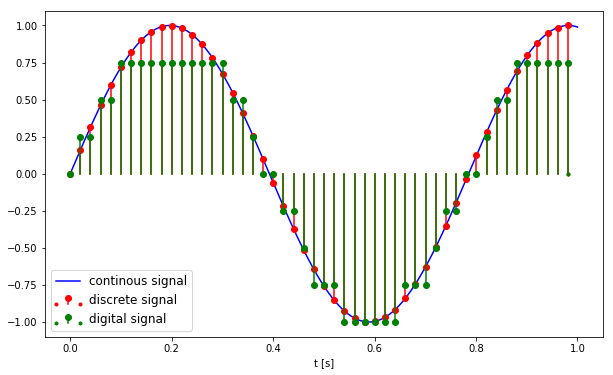

In [196]:
N = 1000  # length of signal

# generate signal
A = 1
f = 4
t = np.linspace(0,1,N)
x = A*np.sin(f*2*t)
t_discr = t[::20]
x_discr = x[::20]

nBits = 3
xQ = [biquant(nBits,-A,A,xi) for xi in x_discr]

# plot (quantized) signals
fig, ax1 = plt.subplots(figsize=(10, 6), facecolor='w', edgecolor='k')

ax1.plot(t,x, 'b', label=r'continous signal')
ax1.stem(t_discr,x_discr,label=r'discrete signal',linefmt='r-', markerfmt='ro', basefmt='r.')
ax1.stem(t_discr,xQ,label=r'digital signal',linefmt='g-', markerfmt='go', basefmt='g.')
ax1.set_xlabel('t [s]')
ax1.legend(fontsize='large',loc=0)

plt.show()

----

## Impulse function:
\begin{equation}
\delta (t) = \begin{cases}
                  \inf & \text{for $t=0$}.\\
                  0 & \text{otherwise}
                \end{cases}
\end{equation}

### The function is defined by the integral:
$$ \int\limits_{-\infty}^\infty \delta (t) dt = 1$$

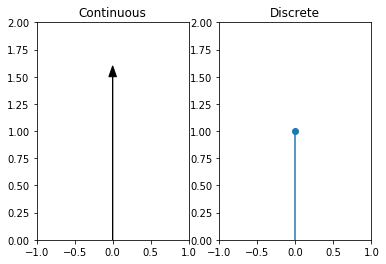

In [197]:
fig, ax = plt.subplots(1,2)
ax[0].arrow(x=0, y=0, dx=0, dy=1.5, head_width=0.1, head_length=0.1, fc='k', ec='k')
ax[0].axis((-1,1,0,2))
ax[0].set_title('Continuous')
ax[1].stem((0,),(1,))
ax[1].axis((-1,1,0,2))
ax[1].set_title('Discrete')
plt.subplots_adjust(hspace=9)
plt.show();

***

## Step function:
\begin{equation}
u (t) = \begin{cases}
                  1 & \text{for $t \geq 0$}.\\
                  0 & \text{otherwise}
                \end{cases}
\end{equation}

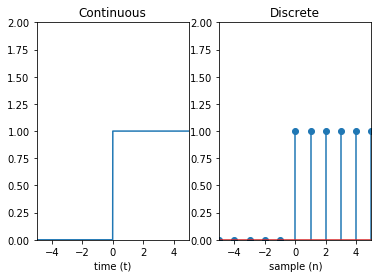

In [198]:
def step_func(t):
    if t >= 0:
        u = 1
    else:
        u = 0
    return u    
        
fig, ax = plt.subplots(1,2)
tc = np.arange(-6,6,1e-2)
td = np.arange(-6,6,1)
uc = np.array([step_func(ti) for ti in tc])
ud = np.array([step_func(ti) for ti in td])
ax[0].plot(tc,uc)
ax[0].axis((-5,5,0,2))
ax[0].set_title('Continuous')
ax[0].set_xlabel('time (t)')
ax[1].stem(td,ud)
ax[1].axis((-5,5,0,2))
ax[1].set_title('Discrete')
ax[1].set_xlabel('sample (n)');

***